# Protein Dizisi Analizi ve Model Karşılaştırması

Bu notebook'ta protein dizilerini analiz edip farklı makine öğrenmesi modellerinin performanslarını karşılaştıracağız.

## Veri Seti
- Kaynak: https://www.kaggle.com/datasets/usamaraheem/human-protein-sequences-and-function-annotations
- İçerik: Protein dizileri ve fonksiyonları

## Veri Seti Hikayesi

Bu veri seti, insan protein dizileri ve bu proteinlerin fonksiyonel anotasyonları hakkında bilgiler içermektedir. İnsan vücudundaki proteinler, biyolojik süreçleri yöneten ve vücut fonksiyonlarını sürdüren önemli bileşenlerdir. Ancak, bir proteinin dizisinin ve fonksiyonunun doğru bir şekilde ilişkilendirilmesi hâlâ büyük bir zorluktur.

Bu veri seti, protein dizilerini ve bunların biyolojik işlevlerini analiz etmeyi amaçlamaktadır. Veri kümesi, özellikle makine öğrenmesi teknikleri kullanarak, protein dizilerinden fonksiyon tahminlerinde bulunmayı hedefler.

Veri kümesindeki temel bileşenler:
- **Protein Dizileri:** Her bir protein için amino asit dizileri.
- **Fonksiyonel Anotasyonlar:** Bu dizilere karşılık gelen biyolojik işlevler.
- **ID’ler:** Her bir proteinin benzersiz kimlikleri.


In [4]:
pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 40.6 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
from Bio import SeqIO
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Modelleri import ediyoruz
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

## Veri Okuma ve Ön İşleme Fonksiyonları

Veri kümesinin doğru bir şekilde yüklenmesi ve protein dizilerinin uygun formatta işlenmesi, modelleme sürecinde önemli bir adımdır. Burada, protein dizilerini FASTA formatında okuyacak ve dizileri temizleyecek bir işleme fonksiyonu oluşturacağız.


In [8]:
def read_fasta(fasta_file):

    # Fasta dosyasını okuyup dataframe'e dönüştürüyoruz
    sequences = []
    identifiers = []

    for record in SeqIO.parse(fasta_file, "fasta"):
        sequences.append(str(record.seq))
        identifiers.append(record.id)

    df = pd.DataFrame({
        'identifier': identifiers,
        'sequence': sequences
    })

    print(f"Toplam {len(df)} protein dizisi okundu")
    return df

In [9]:
# Önişleme(preprocessing) fonksiyonu
def preprocess_sequences(df):

    df['sequence_clean'] = df['sequence'].str.replace('-', '')
    df['sequence_clean'] = df['sequence_clean'].str.replace('X', '')
    df['sequence_clean'] = df['sequence_clean'].str.upper()

    # Dizi uzunluk istatistiklerini gösterme
    print("\nDizi uzunluk istatistikleri:")
    df['length'] = df['sequence_clean'].str.len()
    print(df['length'].describe())

    return df

## Model Değerlendirme Fonksiyonları

Bu bölümde, farklı makine öğrenmesi modellerini uygulayarak performanslarını karşılaştıracağız. Her modelin doğruluk oranını ve sınıflandırma raporunu inceleyeceğiz.


In [10]:
 # Model değerlendirme fonksiyonu
def evaluate_models(X, y):
    """
    Tüm modelleri değerlendirir ve sonuçları döndürür
    """

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Model sözlüğünü oluşturuyoruz
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Random Forest': RandomForestClassifier(),
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'Naive Bayes': GaussianNB(),
        'Decision Tree': DecisionTreeClassifier(),
        'Gradient Boosting': GradientBoostingClassifier()
    }

    results = []

    for model_name, model in models.items():
        print(f"\nDeğerlendiriliyor: {model_name}")

        if model_name in ['Support Vector Machine', 'Naive Bayes']:
            X_train_dense = X_train.toarray()
            X_test_dense = X_test.toarray()
            model.fit(X_train_dense, y_train)
            y_pred = model.predict(X_test_dense)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)

        print(f"Model: {model_name}")
        print(f"Accuracy: {accuracy * 100:.2f}%")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        results.append({
            'Model': model_name,
            'Accuracy': accuracy
        })

    return pd.DataFrame(results)

## Görselleştirme Fonksiyonu

Farklı modellerin doğruluk oranlarını görsel olarak karşılaştırmak, hangi modelin daha iyi performans gösterdiğini hızlıca anlamamıza yardımcı olacaktır.


In [11]:
# Görselleştirme fonksiyonu
def visualize_results(results_df):

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis')
    plt.title('Model Performansları')
    plt.xlabel('Doğruluk Oranı')
    plt.ylabel('Modeller')

    plt.xlim(0, 1)
    plt.xticks([i/10 for i in range(0, 11)],
               [f'{i*10}%' for i in range(0, 11)])

    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

## Veri Yükleme ve Ön İşleme

Öncelikle protein dizilerini FASTA formatında okuyacağız ve bu dizileri temizleyeceğiz. Bu işlem sırasında, istenmeyen karakterleri temizleyecek ve dizileri büyük harfe çevireceğiz.


In [14]:
# FASTA dosyasını okuyoruz
fasta_file = "ALL-HUMAN-0001 SEQUENCES.fasta"
df = read_fasta(fasta_file)

# Dizileri ön işliyoruz
df = preprocess_sequences(df)

Toplam 70956 protein dizisi okundu

Dizi uzunluk istatistikleri:
count    70956.000000
mean       336.889509
std        496.894894
min          7.000000
25%        106.000000
50%        188.000000
75%        405.000000
max      35991.000000
Name: length, dtype: float64


In [15]:
df

,identifier,sequence,sequence_clean,length
0,sp|P27361|MK03_HUMAN,MAAAAAQGGGGGEPRRTEGVGPGVPGEVEMVKGQPFDVGPRYTQLQ...,MAAAAAQGGGGGEPRRTEGVGPGVPGEVEMVKGQPFDVGPRYTQLQ...,379
1,sp|P53779|MK10_HUMAN,MSLHFLYYCSEPTLDVKIAFCQGFDKQVDVSYIAKHYNMSKSKVDN...,MSLHFLYYCSEPTLDVKIAFCQGFDKQVDVSYIAKHYNMSKSKVDN...,464
2,sp|Q15049|MLC1_HUMAN,MTQEPFREELAYDRMPTLERGRQDPASYAPDAKPSDLQLSKRLPPC...,MTQEPFREELAYDRMPTLERGRQDPASYAPDAKPSDLQLSKRLPPC...,377
3,sp|Q9UHC1|MLH3_HUMAN,MIKCLSVEVQAKLRSGLAISSLGQCVEELALNSIDAEAKCVAVRVN...,MIKCLSVEVQAKLRSGLAISSLGQCVEELALNSIDAEAKCVAVRVN...,1453
4,sp|P0DMT0|MLN_HUMAN,MTGKNWILISTTTPKSLEDEIVGRLLKILFVIFVDLISIIYVVITS,MTGKNWILISTTTPKSLEDEIVGRLLKILFVIFVDLISIIYVVITS,46
...,...,...,...,...
70951,tr|F6UFK6|F6UFK6_HUMAN,MWLFFGITGLLTAALSGHPSPAPPDQLNTSSAESELWEPGERLPVR...,MWLFFGITGLLTAALSGHPSPAPPDQLNTSSAESELWEPGERLPVR...,278
70952,tr|J3KS89|J3KS89_HUMAN,XLKELVEPVSRFFEEVNDPAKNDALEMVEETTWQGLKELGAFGLQV...,LKELVEPVSRFFEEVNDPAKNDALEMVEETTWQGLKELGAFGLQVP...,75
70953,tr|F8VVD5|F8VVD5_HUMAN,MLSLSLSPRLECSGPISAHCNLYLPGSSDSPAPTTRVAGITVYQVF...,MLSLSLSPRLECSGPISAHCNLYLPGSSDSPAPTTRVAGITVYQVF...,91
70954,tr|F8W0S2|F8W0S2_HUMAN,MWELRSIAFSRAVFAEFLATLLFVFFGLGSALNWPQALPSVLQIAM...,MWELRSIAFSRAVFAEFLATLLFVFFGLGSALNWPQALPSVLQIAM...,223


## Özellik Çıkarımı

Protein dizilerini sayısal verilere dönüştürmek için, diziler üzerinde n-gram analizi yapacağız. Bu, makine öğrenmesi modelleri için gerekli olan özellik matrisini oluşturacaktır.


In [16]:
# Özellikleri çıkarma
vectorizer = CountVectorizer(analyzer='char', ngram_range=(3,3))
X = vectorizer.fit_transform(df['sequence_clean'])

# Etiketleri belirleme
y = df['identifier'].str[0]

print("Özellik matrisi boyutu:", X.shape)
print("Benzersiz etiket sayısı:", len(np.unique(y)))

Özellik matrisi boyutu: (70956, 8081)
Benzersiz etiket sayısı: 2


## Model Değerlendirme ve Sonuçların Görselleştirilmesi

Farklı makine öğrenmesi modellerini kullanarak, protein dizilerinin fonksiyonlarını tahmin edeceğiz. Her modelin doğruluk oranı ve performansı karşılaştırılacak. Modellerin doğruluk oranlarını bir grafik üzerinde görselleştirerek, hangi modelin en iyi performansı gösterdiğini hızlı bir şekilde değerlendireceğiz.



Değerlendiriliyor: Logistic Regression
Model: Logistic Regression
Accuracy: 76.36%

Classification Report:
              precision    recall  f1-score   support

           s       0.62      0.45      0.52      4057
           t       0.80      0.89      0.84     10135

    accuracy                           0.76     14192
   macro avg       0.71      0.67      0.68     14192
weighted avg       0.75      0.76      0.75     14192


Değerlendiriliyor: Random Forest
Model: Random Forest
Accuracy: 73.77%

Classification Report:
              precision    recall  f1-score   support

           s       0.56      0.38      0.45      4057
           t       0.78      0.88      0.83     10135

    accuracy                           0.74     14192
   macro avg       0.67      0.63      0.64     14192
weighted avg       0.72      0.74      0.72     14192


Değerlendiriliyor: K-Nearest Neighbors
Model: K-Nearest Neighbors
Accuracy: 72.38%

Classification Report:
              precision    recall 

/tmp/ipython-input-2170789402.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis')


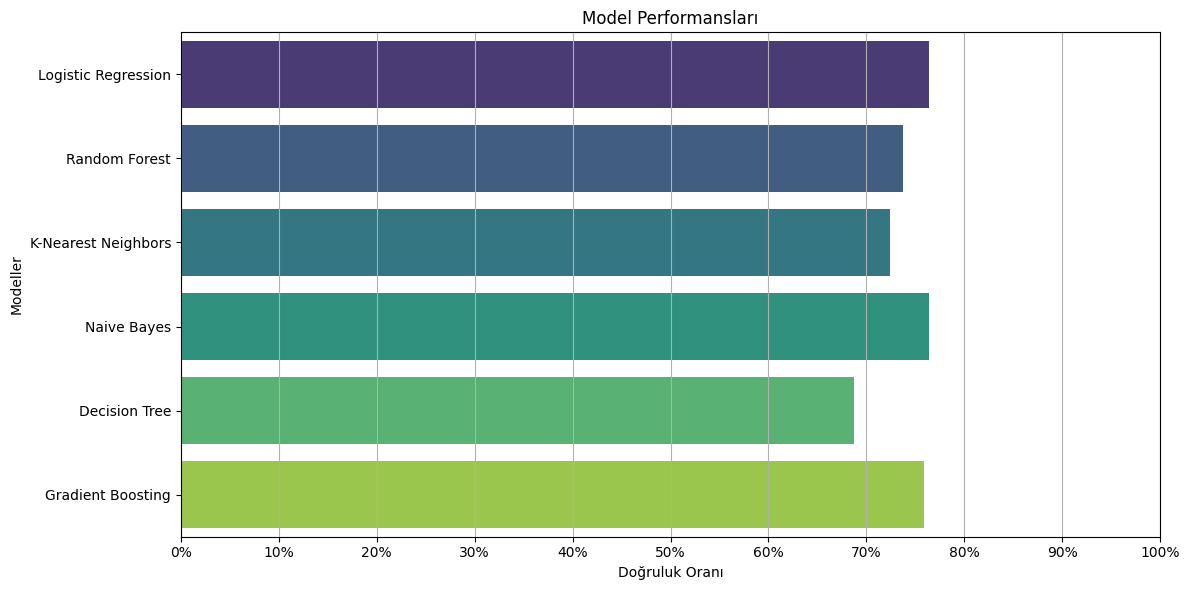


En iyi performans gösteren model:
Model: Naive Bayes
Accuracy: 76.40%


In [17]:
# Tüm modelleri değerlendirme
results_df = evaluate_models(X, y)

# Sonuçları görselleştirme
visualize_results(results_df)

# En iyi modeli yazdırma
best_model = results_df.loc[results_df['Accuracy'].idxmax()]
print(f"\nEn iyi performans gösteren model:")
print(f"Model: {best_model['Model']}")
print(f"Accuracy: {best_model['Accuracy']*100:.2f}%")